In [224]:
import sys
sys.path.append("..")

# basics
import numpy as np
import scipy
import matplotlib.pyplot as plt
import copy
import qutip.floquet as floq

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tukey as tukey
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

In [226]:
def cost(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude, ramp_coeff]
    amplitude = constants[0]
    ramp_coef = constants[1]
    tlist = np.linspace(0, duration, int(duration*5))
    tukey.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    print(fidelity, offset, duration)
    return (1-fidelity)

result1 = scipy.optimize.minimize(cost, [0.2745454545454544, 80], [2.5*2*np.pi, 0.5], method="Nelder-Mead", options={"disp":True})

0.007983980961774039 0.2745454545454544 80.0
0.3790990246288782 0.2882727272727272 80.0
0.5152749083734746 0.2745454545454544 84.0
0.03018502591998787 0.28827272727272724 84.0
0.02508165188912632 0.28484090909090903 83.0
0.019321233922874288 0.28140909090909083 82.0
0.24176197753457918 0.2745454545454544 82.0
0.44905183230200296 0.267681818181818 84.0
0.15595465899159255 0.267681818181818 86.0
0.4555839603555759 0.2728295454545453 83.0
0.19202298853545668 0.2796931818181817 83.0
0.522670908095697 0.27068465909090894 83.75
0.5130667278563025 0.272400568181818 84.75
0.5310750387945286 0.27250781249999984 84.3125
0.47183438890045754 0.26864701704545435 84.0625
0.5297059695566958 0.27307084517045443 84.015625
0.5409171309479867 0.2748939985795453 84.578125
0.5462107226905544 0.27699866832386344 84.9921875
0.5517452533764156 0.2764356356534088 85.2890625
0.5580070680779903 0.27811803089488596 85.92578125
0.576954368248215 0.28260888671874956 86.60546875
0.5869720159709472 0.2876594238281243

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

0.21399532787569284


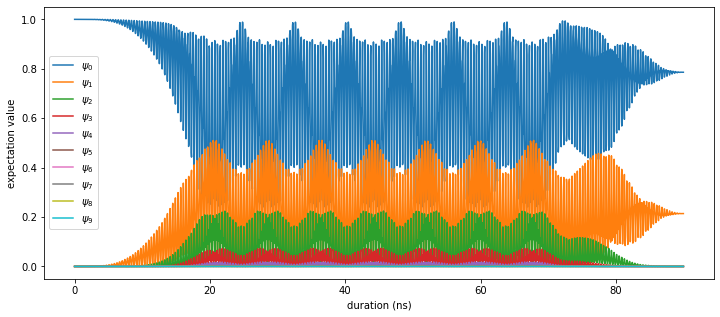

In [237]:
# 0.9990697298060399 0.3898644953695122 128.81398725509644
t_max = 90
offset = 0.28
freq = system.first_energy_spacing/3 - offset
durations = np.arange(0, _t_max, (2*np.pi)/(freq*20))
amp = 15

tukey.setup(amp, freq, 0.5, durations)

s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, durations, system.starting_state, pbar=True)

graph.graph_solution(s, system)
print(expv.expectation_value(s.final_state, system.target_state))


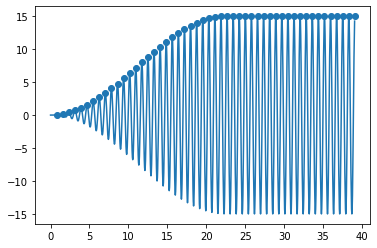

In [238]:
dur_points = np.arange(0, _t_max, (2*np.pi)/(freq))[::1]
dur_points = dur_points[1:-1]
pulse = tukey.get_pulse(durations)
num_of_points = 1000
num_of_durPoints = 50

plt.plot(durations[:num_of_points], pulse[:num_of_points])
plt.scatter(dur_points[:num_of_durPoints], tukey.get_pulse(dur_points)[:num_of_durPoints])


In [248]:
_sort_indices = []
def sort_kets_constant(kets, reset=False):
    global _sort_indices
    if reset or len(_sort_indices) == 0:
        _sort_indices = []
        for ket in kets:
            i = np.argmax(ket.full())
            _sort_indices.append(i)

    sorted_kets = list(np.zeros(len(kets)))
    for i in _sort_indices:
        idx = _sort_indices[i]
        sorted_kets[i] = kets[idx]
    return sorted_kets

def sort_kets(kets, debug=False):
    sorted_kets = list(np.zeros(len(kets)))
    sorted_indices = []
    used_idxs = set()
    unused_kets = []
    for i in range(len(kets)):
        ket = kets[i]
        idx = np.argmax(ket.full())
        sorted_indices.append(idx)
        if not idx in used_idxs:
            used_idxs.add(idx)
            sorted_kets[idx] = ket
        else:
            unused_kets.append(ket)
    
    for ket in unused_kets:
        for i in range(len(sorted_kets)):
            if sorted_kets[i] == 0:
                sorted_kets[i] = ket
                break

    if debug:
        print(sorted_indices)
    
    return sorted_kets

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.amin(np.abs(array - value)) > 1e-12:
        print("error, duration does not exactly exist!", value, array[idx])
    return idx

def overlap(state1, state2):
    return (np.transpose(np.matrix(state1.full())) * np.matrix(state2.full())).item()

In [249]:
overlap(system.basis_states[0], (system.basis_states[0]+system.basis_states[1])/2)

(0.5+0j)

In [241]:
# dur = dur_points[50]
# dur_amp = tukey.pulse_func(dur)
# def steady(t, args=None):
#     return dur_amp * np.cos(freq * t)
# H = [system.H0, [system.H1, steady]]

# floquet_kets_50, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
# sorted_floquet_kets = sort_kets(floquet_kets_50)
# index_of_dur = find_nearest(durations, dur)

# # t_diff = dur_points[15] - dur_points[16]
# # f_modes_t = floq.floquet_modes_t(floquet_kets, quasi_energies, t_diff, H, (2*np.pi)/freq, args=None)
# expv.expectation_value(s.states[index_of_dur], sorted_floquet_kets[1])

In [270]:
overlaps = []
for dur in dur_points:
    dur_amp = tukey.pulse_func(dur)
    def steady(t, args=None):
        return dur_amp * np.cos(freq * t)
    H = [system.H0, [system.H1, steady]]

    floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
    sorted_floquet_kets = sort_kets(floquet_kets)
    if len(floquet_kets) < 10:
        print("error not enough kets!")
        input()
    if len(sorted_floquet_kets) < 10:
        print("error not enough sorted kets!")
        input()
    index_of_dur = find_nearest(durations, dur)
    overlaps_at_this_dur = []
    for floquet_ket in list(sorted_floquet_kets):
        if type(floquet_ket) == np.float64:
            print(floquet_ket)
            overlaps_at_this_dur.append(0)
            continue
        # o = expv.expectation_value(s.states[index_of_dur], floquet_ket)
        o = overlap(s.states[index_of_dur], floquet_ket)
        overlaps_at_this_dur.append(o)
    overlaps.append(np.array(overlaps_at_this_dur))

In [271]:
overlaps = np.array(overlaps)
print(overlaps.shape)
# overlaps = np.transpose(overlaps)

(114, 10)


(-0.1, 1.1)

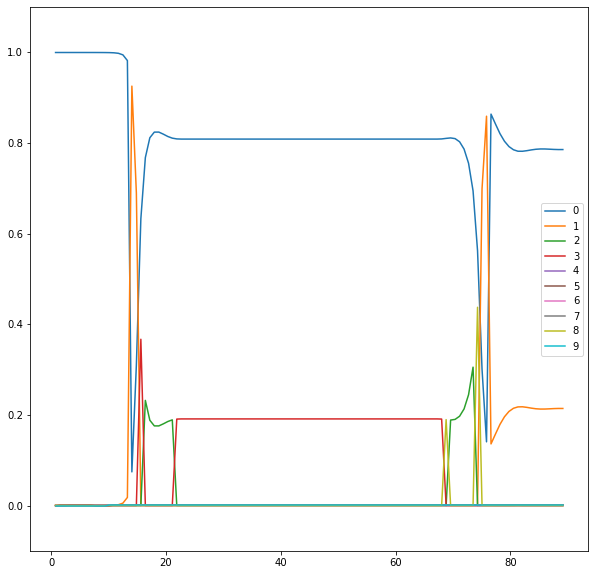

In [267]:
a = []
for o in overlaps:
    a.append(o[0])

labeled_overlaps = np.linspace(0,len(overlaps))

plt.figure(figsize=(10,10))
for i in range(0, len(overlaps)):
    o = overlaps[i]
    plt.plot(dur_points, o, label=i)
# plt.plot(dur_points, overlaps, label=labeled_overlaps)
plt.legend()
plt.ylim((-0.1, 1.1))

In [ ]:
# I know we mentioned needing to make sure phases were all the same but it seems like that is taken care of since the numbers pan out, but maybe for overlap I am missing that

In [235]:
import importlib
importlib.reload(graph)

<module 'utils.graph' from '../utils/graph.py'>

/var/folders/8w/jht5wjcd4kl492xz8hs9lft40000gn/T/ipykernel_79634/4133477946.py:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


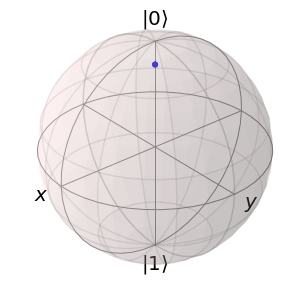

<Figure size 360x360 with 0 Axes>

In [294]:
import qutip
to_plot = []
# for dur in dur_points:
#     dur_amp = tukey.pulse_func(dur)
#     def steady(t, args=None):
#         return dur_amp * np.cos(freq * t)
#     H = [system.H0, [system.H1, steady]]

#     floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
#     sorted_floquet_kets = sort_kets(floquet_kets, debug=True)
#     to_plot.append(sorted_floquet_kets[0])
#     # computational subspace is the overlap into 0th and 1st floquet states?

xs = []
ys = []
zs = []
vecs = []
for i in range(0, len(overlaps)):
    c0 = overlaps[i,0]
    c1 = overlaps[i,3]
    xs.append( np.conjugate(c0) * c1 + c0 * np.conjugate(c1) )
    ys.append( -1j * np.conjugate(c0) * c1 + 1j * c0 * np.conjugate(c1) )
    zs.append( np.conjugate(c0) * c0 - c1 * np.conjugate(c1) )

    # xs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmax()))
    # ys.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmay()))
    # zs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmaz()))
    vecs.append([xs[-1], ys[-1], zs[-1]])

from matplotlib import pyplot, animation
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig, azim=-40, elev=30)
sphere = qutip.Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_points([xs[i:i+1], ys[i:i+1], zs[i:i+1]])
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(xs)),
                            init_func=init, blit=False, repeat=False)

ani.save('%s_bloch_sphere.mp4' % "test", fps=20)

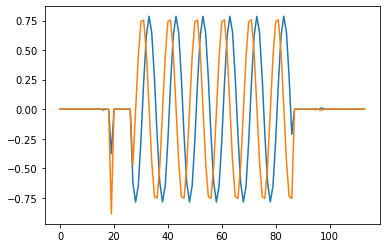

In [292]:

plt.plot(ys)
plt.plot(xs)

In [283]:
np.abs(overlaps[50][0])**2

0.8088642173951894

In [284]:
np.abs(overlaps[50][3])**2

0.19113107502264196